# News Article Matrix Factorization

---

Unsupervised classification applied to BBC News articles.

This project derives from the Kaggle competition with the same name, found here: https://www.kaggle.com/competitions/learn-ai-bbc/overview


## Kaggle Information:

### Description:

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

### Evaluation:

The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

### Citation: 

Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Text Cleanup](#textclean)
  - 3.3. [Missing Data](#missingdata)
  - 3.4. [Checking for Duplicate Entries](#duplicates)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Energy Load Data: <a name="loaddata"></a>

Electrical load and generation data was gathered from Pennsylvania-New Jersey-Maryland Interconnection, now called PJM, which is a regional transmission organization (RTO) that coordinates movement of electricity in 13 states and Washington, DC. 

**Data Info:**
- Detailed dataset documentation can be found at https://dataminer2.pjm.com/feed/hrl_load_metered/definition.
- Accessed and obtained on 3/28/2024.
- Ranges from 1/1/1993 to 3/27/2024.
- Hourly frequency.

- **Feature Information**
    - **Datetime Beginning UTC:** Hourly datetime in UTC.
    - **Datetime Beginning EPT:** Hourly datetime in EPT.
    - **NERC Region:** North American Electric Reliability Corporation (NERC) Regions
    - **Market Region:** Designation of utility market data belongs to.
    - **Transmission Zone:** Zone where the electricity transmission occurs. Flagged by a string of the energy company(s)' name.
    - **Load Area:** Metered electric distribution company.
    - **MW:** Electrical load measured in Megawatts (MW).
    - **Company Verified:** Indicates whether the metered load has been verified by the electric distribution company.

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [225]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from wordcloud import WordCloud



###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [226]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [227]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [228]:
# Add and sort all filenames from each folder path.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
file_path = sorted(file_path)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
train = pd.read_csv(data_folder + '/BBC News Train.csv.gz', compression = 'gzip')
X_test = pd.read_csv(data_folder + '/BBC News Test.csv.gz', compression = 'gzip')
y_test = pd.read_csv(data_folder + '/BBC News Sample Solution.csv.gz', compression = 'gzip')

###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

In [229]:
print('Train\n####################')
display(train)
print(train.dtypes)
print('\nTest\n####################')
print(X_test.columns.to_list())
print(X_test.shape)
print(y_test.columns.to_list())
print(y_test.shape)

Train
####################


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


ArticleId     int64
Text         object
Category     object
dtype: object

Test
####################
['ArticleId', 'Text']
(735, 2)
['ArticleId', 'Category']
(735, 2)


In [230]:
# Build custom color map for consistent label visualization.
category_cmap = {'business' : '#012A36',
                 'tech' : '#D16666',
                 'politics' : '#078060',
                 'sport' : '#29274C',
                 'entertainment' : '#FFF275'}

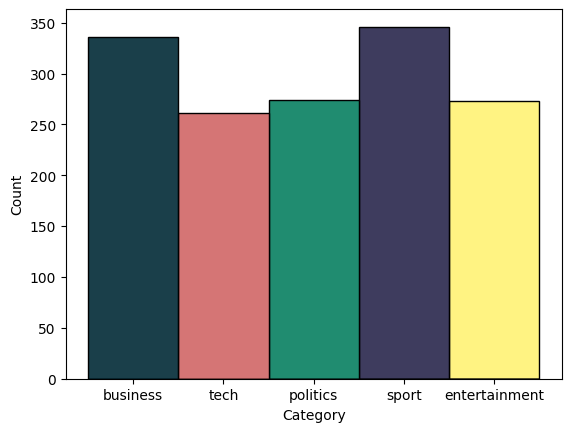

In [231]:
sns.histplot(train, x = 'Category', hue = 'Category', palette = category_cmap, legend = False, alpha = 0.9)
plt.show()

In [232]:
# Choose random text to display.
print(train.Text[25])
print(' -  -  - ')
print(train.Text[20])
print(' -  -  - ')
print(train.Text[500])

china had role in yukos split-up china lent russia $6bn (£3.2bn) to help the russian government renationalise the key yuganskneftegas unit of oil group yukos  it has been revealed.  the kremlin said on tuesday that the $6bn which russian state bank veb lent state-owned rosneft to help buy yugansk in turn came from chinese banks. the revelation came as the russian government said rosneft had signed a long-term oil supply deal with china. the deal sees rosneft receive $6bn in credits from china s cnpc.  according to russian newspaper vedomosti  these credits would be used to pay off the loans rosneft received to finance the purchase of yugansk. reports said cnpc had been offered 20% of yugansk in return for providing finance but the company opted for a long-term oil supply deal instead. analysts said one factor that might have influenced the chinese decision was the possibility of litigation from yukos  yugansk s former owner  if cnpc had become a shareholder. rosneft and veb declined to

###### [Back to Table of Contents](#toc)

### 3.2. Text Cleanup: <a name="textclean"></a>

We can see that while there looks to have been some text preprocessing already done, there are a few more steps to be taken before more exploratory data analysis can be done and then into word embedding.

**Pre-processing done already:**
1. All letters are lowercase.
2. Apostrophes have been removed (e.g. `from yukos  yugansk s former owner` and `for next week s australian open`).

However, these have only been observed from a small sample of the text, so will be checked to ensure this is the case in the entire corpus.

**Pre-processing to be done:**
1. Remove special characters.
2. Remove punctuation.
3. Remove extra spaces.
4. Remove "stop words" (e.g. `the`, `is`, `a`, `an`, `for`, etc).
5. Tokenize words (e.g. `amazingly few discotheques provide jukeboxes` $\rightarrow$ `[amazingly], [few], [discotheques], [provide], [jukeboxes]`).

**Optional Pre-processing (to be determined during model fine-tuning):**
1. Lammatize words, reducing words to their roots (e.g. `striking` $\rightarrow$ `strike` or `strikes` $\rightarrow$ `strike`).

*Note: As this project is intended for classification using matrix factorization, removing stop words, plurals, and punctuation poses little risk in negatively affecting the model's abilities. However, if semantics or other NLP applications were intended, much of sentence meaning can be lost without careful application of these techniques. Arguably, though, including special characters such as "$" could increase accuracy in classifying certain categories.*

In [233]:
def clean_corpus(df, column):
    # Remove hyphens and replace with space.
    df['hyphen'] = df[column].apply(lambda x: re.sub(r'-', ' ', x))
    # Remove anything that isn't a latter, number, or space.
    df['alpha_only'] = df['hyphen'].apply(lambda x: re.sub(r'[^ a-zA-Z0-9]+', '', x))
    # Remove any extra spaces.
    df['extra_spaces'] = df['alpha_only'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
    # Remove stop words.
    stops = set(stopwords.words('english')) # Set lookup is faster.
    df['cleaned'] = df['extra_spaces'].apply(lambda x: ' '.join([word for word in x.split() if word not in stops]))
    
    return

In [234]:
clean_corpus(train, 'Text')

In [235]:
print('Processed:', train.cleaned[25])
print('Original: ', train.Text[25])
print(' -  -  - ')
print('Processed:', train.cleaned[20])
print('Original: ', train.Text[20])
print(' -  -  - ')
print('Processed:', train.cleaned[500])
print('Original: ', train.Text[500])
print(' -  -  - \n -  -  - ')
print('Set Difference Example:', set(train.Text[25].split()) - set(train.cleaned[25].split()))

Processed: china role yukos split china lent russia 6bn 32bn help russian government renationalise key yuganskneftegas unit oil group yukos revealed kremlin said tuesday 6bn russian state bank veb lent state owned rosneft help buy yugansk turn came chinese banks revelation came russian government said rosneft signed long term oil supply deal china deal sees rosneft receive 6bn credits china cnpc according russian newspaper vedomosti credits would used pay loans rosneft received finance purchase yugansk reports said cnpc offered 20 yugansk return providing finance company opted long term oil supply deal instead analysts said one factor might influenced chinese decision possibility litigation yukos yugansk former owner cnpc become shareholder rosneft veb declined comment two companies rosneft cnpc agreed pre payment long term deliveries said russian oil official sergei oganesyan nothing unusual pre payment five six years announcements help explain rosneft medium sized indebted relatively

In [236]:
def tokenizer(df):
    df['tokens'] = df['cleaned'].apply(lambda x: x.split())
    
    return

In [237]:
tokenizer(train)
print(train.tokens[25])
train.tokens[train.tokens.apply(lambda x: 'china' in x)]

['china', 'role', 'yukos', 'split', 'china', 'lent', 'russia', '6bn', '32bn', 'help', 'russian', 'government', 'renationalise', 'key', 'yuganskneftegas', 'unit', 'oil', 'group', 'yukos', 'revealed', 'kremlin', 'said', 'tuesday', '6bn', 'russian', 'state', 'bank', 'veb', 'lent', 'state', 'owned', 'rosneft', 'help', 'buy', 'yugansk', 'turn', 'came', 'chinese', 'banks', 'revelation', 'came', 'russian', 'government', 'said', 'rosneft', 'signed', 'long', 'term', 'oil', 'supply', 'deal', 'china', 'deal', 'sees', 'rosneft', 'receive', '6bn', 'credits', 'china', 'cnpc', 'according', 'russian', 'newspaper', 'vedomosti', 'credits', 'would', 'used', 'pay', 'loans', 'rosneft', 'received', 'finance', 'purchase', 'yugansk', 'reports', 'said', 'cnpc', 'offered', '20', 'yugansk', 'return', 'providing', 'finance', 'company', 'opted', 'long', 'term', 'oil', 'supply', 'deal', 'instead', 'analysts', 'said', 'one', 'factor', 'might', 'influenced', 'chinese', 'decision', 'possibility', 'litigation', 'yukos'

2       [bbc, poll, indicates, economic, gloom, citize...
17      [hantuchova, dubai, last, eight, daniela, hant...
25      [china, role, yukos, split, china, lent, russi...
32      [china, continues, rapid, growth, china, econo...
46      [china, ripe, media, explosion, asia, set, dri...
                              ...                        
1371    [gadget, growth, fuels, eco, concerns, technol...
1375    [musicians, tackle, us, red, tape, musicians, ...
1382    [yukos, seeks, court, action, sale, yukos, ret...
1417    [ticking, budget, facing, us, budget, proposal...
1461    [speech, takes, search, engines, scottish, fir...
Name: tokens, Length: 62, dtype: object

###### [Back to Table of Contents](#toc)

### 3.3. Missing Data: <a name="missingdata"></a>

In [238]:
# Check to ensure no empty tokens.
train.tokens[train.tokens.apply(lambda x: ' ' in x)]

Series([], Name: tokens, dtype: object)

In [239]:
train.isna().sum()

ArticleId       0
Text            0
Category        0
hyphen          0
alpha_only      0
extra_spaces    0
cleaned         0
tokens          0
dtype: int64

In [240]:
display(X_test.isna().sum())
display(y_test.isna().sum())

ArticleId    0
Text         0
dtype: int64

ArticleId    0
Category     0
dtype: int64

### 3.4. Checking for Duplicate Entries: <a name="duplicates"></a>

In [241]:
print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

drop_idx = train[train.Text.duplicated()].index
train = train.drop(drop_idx, axis = 0)

print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

Duplicates Found: 50
DF Shape: (1490, 8)
Duplicates Found: 0
DF Shape: (1440, 8)


###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

In [242]:
token_freq = train.explode('tokens').groupby(['tokens'], as_index=True)['tokens'].count().reset_index(
    name = 'frequency').sort_values('frequency', ascending = False)
token_freq

,tokens,frequency
19814,said,4694
15376,mr,1896
24899,would,1652
25020,year,1485
2291,also,1366
...,...,...
17904,projection,1
2324,amaya,1
10080,fudge,1
10079,fuck,1


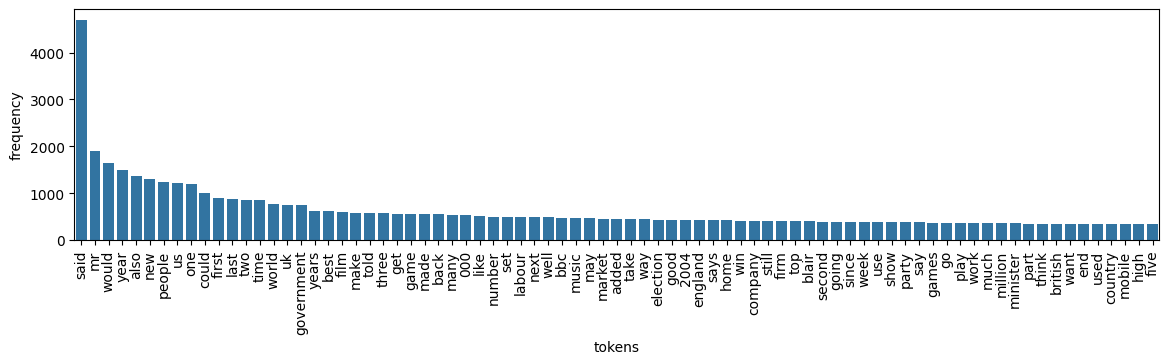

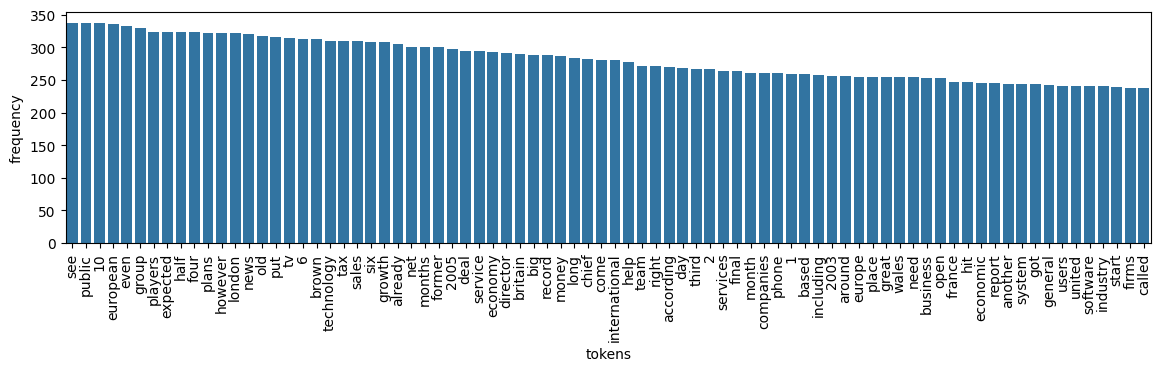

In [243]:
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[0:79], x = 'tokens', y = 'frequency')
plt.xticks(rotation = 90)
plt.show()
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[79:159], x = 'tokens', y = 'frequency')
plt.xticks(rotation = 90)
plt.show()

In [244]:
token_cat_freq = train.explode('tokens').groupby(['Category', 'tokens'], as_index=True)['tokens'].count().reset_index(name = 'frequency').sort_values('frequency', ascending = False)
token_cat_freq

,Category,tokens,frequency
26912,politics,said,1412
7902,business,said,1098
25174,politics,mr,1038
45233,tech,said,980
28748,politics,would,685
...,...,...,...
14792,entertainment,involves,1
14793,entertainment,inwhich,1
14794,entertainment,iphigenia,1
31917,sport,feint,1


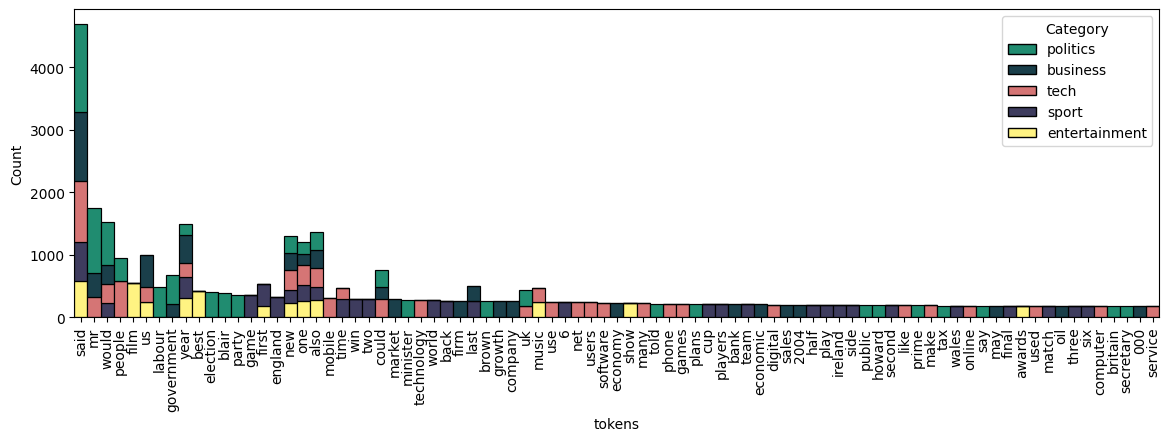

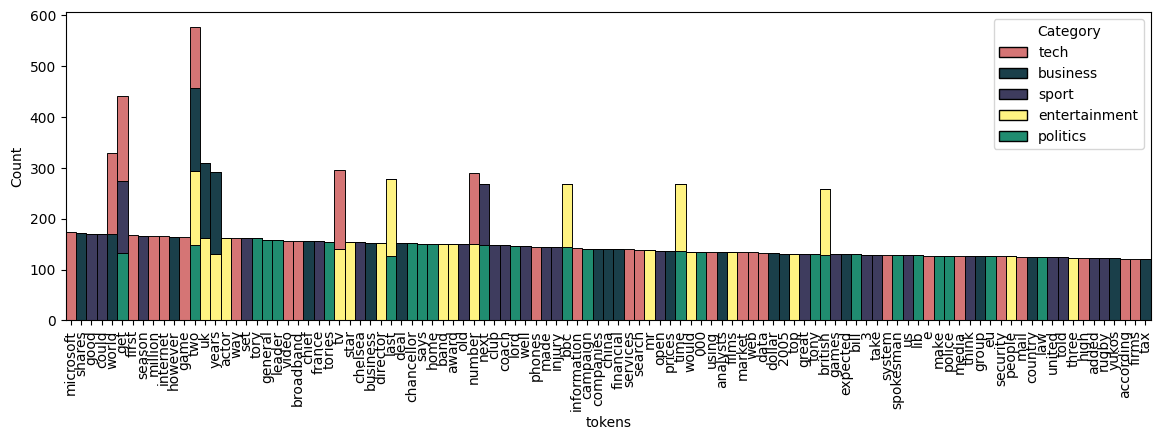

In [245]:
plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[0:119], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[119:239], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

In [246]:
# Article lengths post tokenization.
train['article_len'] = train['tokens'].apply(lambda x: len(x))

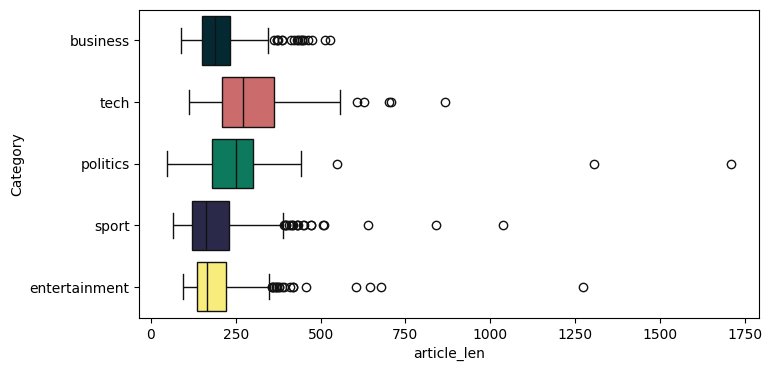

In [247]:
plt.subplots(figsize = (8, 4))
sns.boxplot(train, x = 'article_len', y = 'Category', hue = 'Category', palette = category_cmap, saturation = 0.9)
plt.show()

In [248]:
# Create gradient color maps for each category.
# Unnecessary, probably, but looks great!

n = 256
# Business
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(1/256, 1, n)
vals[:, 1] = np.linspace(42/256, 1, n)
vals[:, 2] = np.linspace(54/256, 1, n)
cmp_business = ListedColormap(vals)

# Tech
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(209/256, 1, n)
vals[:, 1] = np.linspace(102/256, 1, n)
vals[:, 2] = np.linspace(102/256, 1, n)
cmp_tech = ListedColormap(vals)

# Politics
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(3/256, 1, n)
vals[:, 1] = np.linspace(64/256, 1, n)
vals[:, 2] = np.linspace(48/256, 1, n)
cmp_politics = ListedColormap(vals)

# Sport
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(41/256, 1, n)
vals[:, 1] = np.linspace(39/256, 1, n)
vals[:, 2] = np.linspace(76/256, 1, n)
cmp_sport = ListedColormap(vals)

# Entertainment
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(161/256, 1, n)
vals[:, 1] = np.linspace(152/256, 1, n)
vals[:, 2] = np.linspace(72/256, 1, n)
cmp_entertainment = ListedColormap(vals)

# Create dictionary to call during plotting.
category_cmap_gradient = dict(zip(category_cmap.keys(), [cmp_business, cmp_tech, cmp_politics, cmp_sport, cmp_entertainment]))

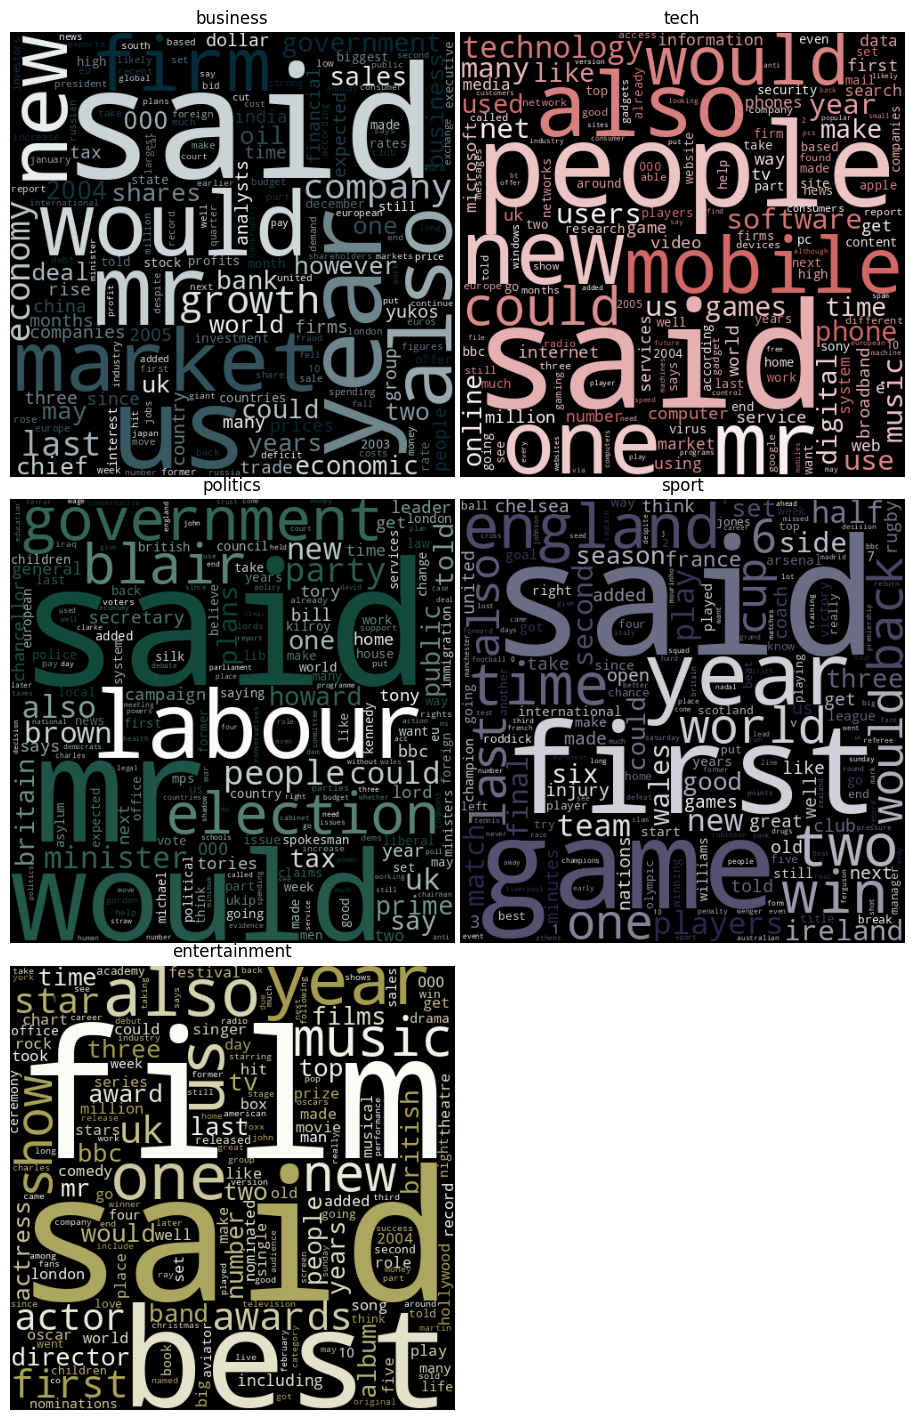

In [249]:
fig, ax = plt.subplots(3, 2, figsize = (9, 14), sharey = False, sharex = False)
for i, cat in enumerate(category_cmap.keys()):
    cloud = WordCloud(width = 500, height = 500, min_font_size = 8, colormap = category_cmap_gradient[cat]).generate_from_frequencies(
        token_cat_freq[token_cat_freq['Category'] == cat][['tokens', 'frequency']].set_index('tokens').to_dict()['frequency'])
    ax[i//2, i%2].imshow(cloud)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(cat)

fig.delaxes(ax[(2,1)])
plt.tight_layout(pad = 0)

## 5. Word Embedding

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer



###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. Quick resource on stop word removal in Python - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
2. Regex to remove extra whitespace - https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string

###### [Back to Table of Contents](#toc)